In [1]:
# Modelin Biological Networks Assignment
#
# Jan Sternagel, 102177941
import numpy as np
import pandas as pd
import pysindy as ps
from ipywidgets import interact

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


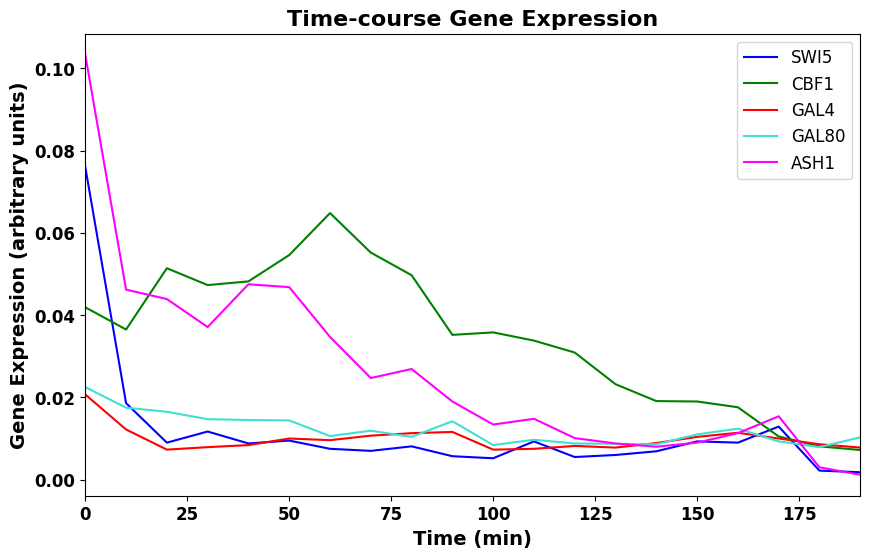

In [2]:
from src.commons import read_data
from src.visuals import show_gene_expression_over_time_in_one_plot

t, data_gen_exp_t = read_data('data/data_original.json')

dt = 10  # min
max_time = max(t)

t_data = np.array(t)
x_true = np.array(list(data_gen_exp_t.values())).T

show_gene_expression_over_time_in_one_plot(t, data_gen_exp_t)

# Relevance Networks

In [3]:
from src.relevance_network import compute_mutual_info_matrix

# Start with Relevance Network
df = pd.DataFrame(data_gen_exp_t)

# Calculate correlation matrix
correlation_matrix = df.corr()
mi_matrix = compute_mutual_info_matrix(df)

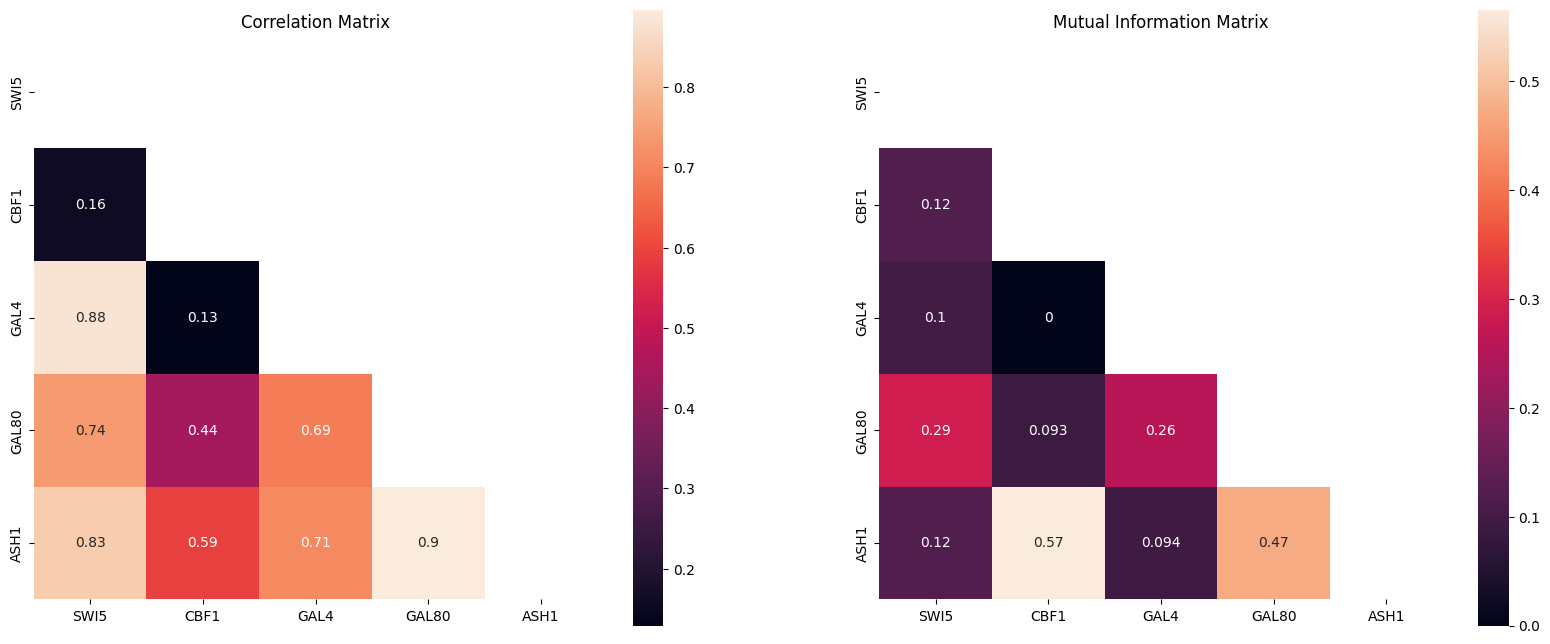

In [4]:
from src.visuals import plot_corr_and_mi_matrices

plot_corr_and_mi_matrices(correlation_matrix, mi_matrix)

In [5]:
from src.visuals import plot_relevance_graph
from matplotlib import pyplot as plt


@interact(threshold=(0.0, 1.0))
def widget_plot(threshold):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))  # Create a figure with two subplots

    plot_relevance_graph(axs[0], threshold, mi_matrix, "Mutual Information Graph")
    plot_relevance_graph(axs[1], threshold, correlation_matrix, "Correlation Graph")

    plt.show()


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

In [6]:
from src.relevance_network import apply_dpi

dpi_threshold = 0.3  # Threshold for DPI
threshold = 0.0
aracne_result = apply_dpi(mi_matrix, threshold, dpi_threshold)
print(aracne_result)

[[1.63523966 0.         0.         0.28779651 0.        ]
 [0.         1.71440632 0.         0.         0.56594791]
 [0.         0.         1.63940632 0.25763504 0.        ]
 [0.28779651 0.         0.25763504 1.69773966 0.4727391 ]
 [0.         0.56594791 0.         0.4727391  1.71440632]]


# Gradient Estimation
Using brute force for all  possible ODE models.
PySINDy is a good library for that and will be used a lot

In [7]:
# Sadly the data is WAY too little. Let's fake 500 repeats of the same experiment with an unrealistic noise. In the future we would need to messure much more!
n_trajectories = 500
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(x_true + np.random.normal(0, 0.00001, x_true.shape))

In [8]:
# Define the library and identify all the features
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(x_true, {"ax_sample": 0, "ax_coord": 1})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


In [9]:
# 1. Start of with an unconstrained model to establish a baseline, this is very over-fitted!
model_unconstrained = ps.SINDy(optimizer=ps.STLSQ(threshold=0.001), feature_library=library)
model_unconstrained.fit(x_true, t=dt)
# model_unconstrained.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Unconstrained Model:")
model_unconstrained.print()

Unconstrained Model:
(x0)' = -0.090 x0 + 0.032 x2 + 0.017 x3 + 0.011 x4 + -0.335 x4^2
(x1)' = -0.018 x0
(x2)' = -0.016 x0 + 0.002 x4
(x3)' = -0.005 x4
(x4)' = -0.050 x0 + 0.007 x1 + -0.105 x2 + 0.107 x3 + -0.008 x4 + -0.411 x4^2


Model score against true model: 0.625903


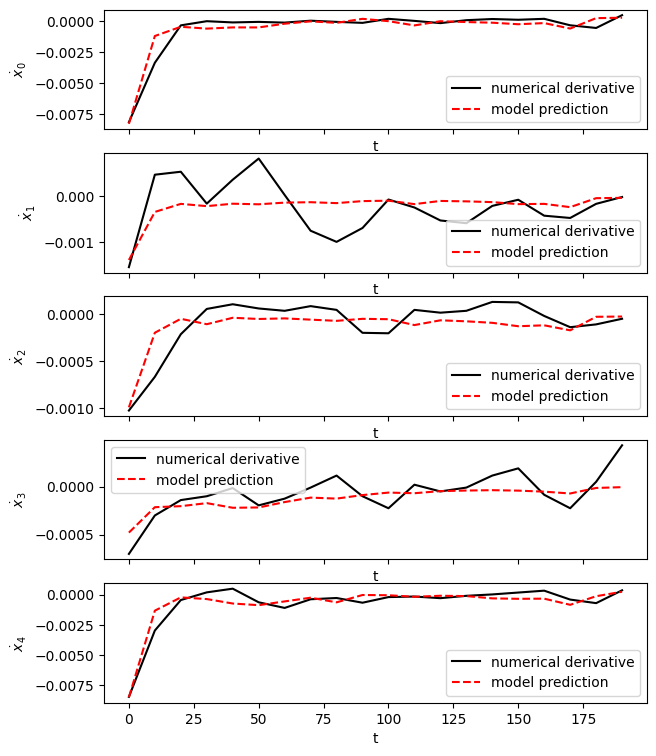

In [10]:
from src.visuals import plot_model_prediction

print("Model score against true model: %f" % model_unconstrained.score(x_true, t=dt))
plot_model_prediction(model_unconstrained, x_true, dt, max_time)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0065326633165829154) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0065326633165829154) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.007035175879396985) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stl

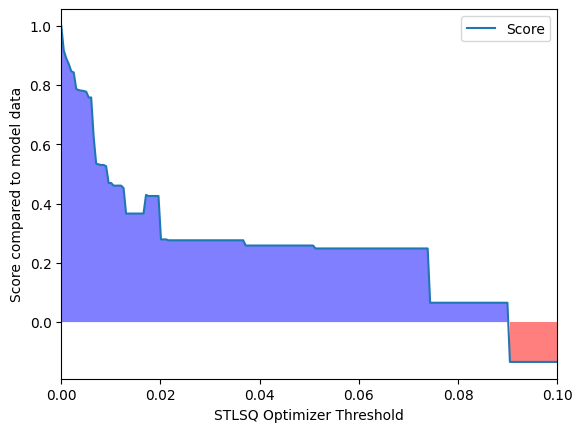

In [11]:
from src.visuals import plot_scores_over_threshold

# 2. Experiment with the threshold
threshold_scan = np.linspace(0, 0.1, 200)
scores = []
for i, threshold in enumerate(threshold_scan):
    optimizer = ps.STLSQ(threshold=threshold)
    model_threshold = ps.SINDy(optimizer=optimizer, feature_library=library)
    # model_threshold.fit(x_true, t=dt)
    model_threshold.fit(x_train_multi, t=dt, multiple_trajectories=True)
    scores.append(model_threshold.score(x_true, t=dt))

plot_scores_over_threshold(threshold_scan, scores)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0166) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0166) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0166) and eliminated all coefficients
  warnings.warn(


Best threshold model:
(x0)' = -0.076 x0 + 0.033 x1 + -0.035 x4
(x1)' = -0.018 x0
(x2)' = 0.000
(x3)' = 0.000
(x4)' = -0.012 x0 + -0.010 x2 + -0.947 x0 x4
Model score against true model: 0.366387


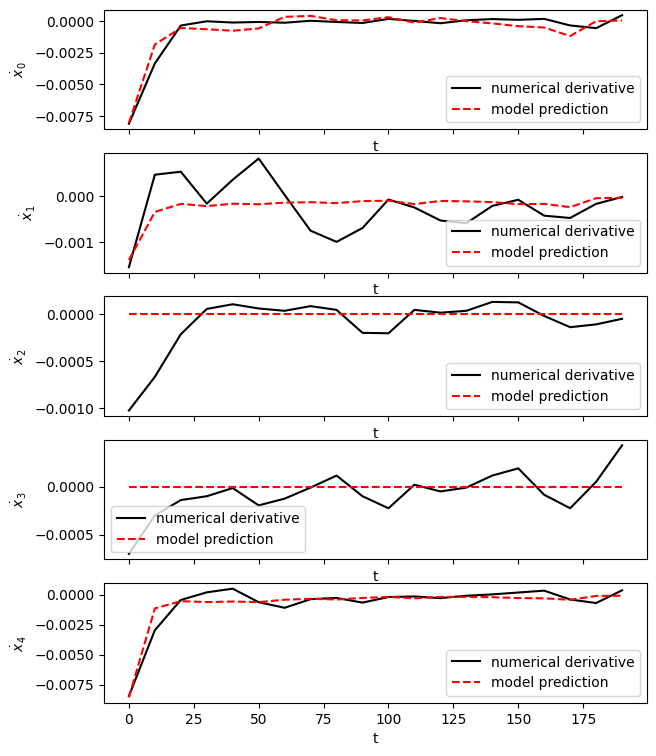

In [12]:
from src.visuals import create_graph_from_model, draw_graph, format_model_for_graph_plot

# Pick the "best" one manually and view it
model_threshold_best = ps.SINDy(optimizer=ps.STLSQ(threshold=0.01660), feature_library=library)
# model_threshold_best.fit(x_true, t=dt)
model_threshold_best.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Best threshold model:")
model_threshold_best.print()

print("Model score against true model: %f" % model_threshold_best.score(x_true, t=dt))
plot_model_prediction(model_threshold_best, x_true, dt, max_time)

Equality Constrained Model
(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
(x3)' = 0.000
(x4)' = 0.000
Model score against true model: -0.134411


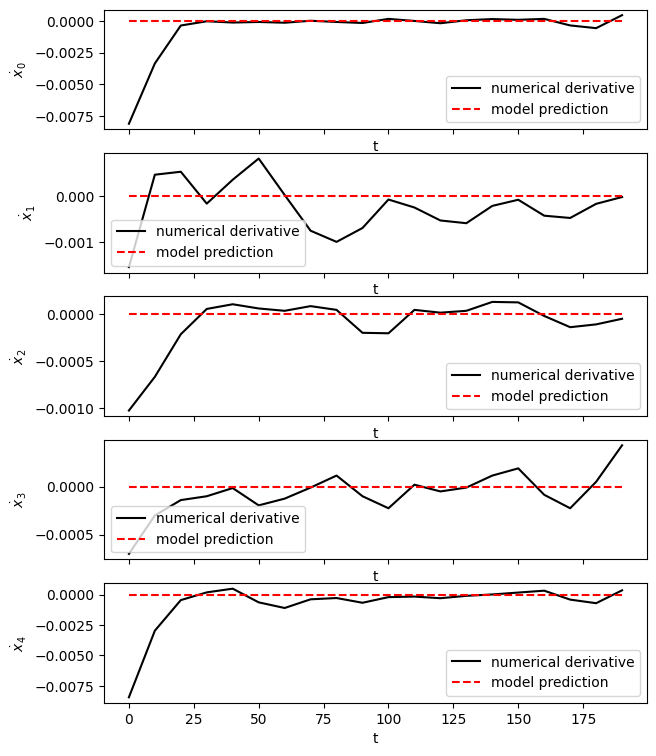

In [13]:
from src.pysindy_gradiet_estimation import translate_model_to_spare_array, pruned_model_optimizer_equality

rna_to_element_translation: dict = {"SWI5": "x0", "CBF1": "x1", "GAL4": "x2", "GAL80": "x3", "ASH1": "x4"}

model_equality_constrained_only_linear = {
    "SWI5": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "CBF1": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "GAL4": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "GAL80": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "ASH1": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]
}

model_equality_constrained_true_model = {
    "SWI5": ["GAL4"],
    "CBF1": ["SWI5", "ASH1"],
    "GAL4": ["CBF1", "GAL80"],
    "GAL80": ["SWI5"],
    "ASH1": ["SWI5"]
}

# Select which one to chose
selected_model = model_equality_constrained_true_model

translated_model = translate_model_to_spare_array(rna_to_element_translation, library.get_feature_names(),
                                                  selected_model)
model_equality_constrained = ps.SINDy(
        optimizer=pruned_model_optimizer_equality(translated_model),
        feature_library=library
)
# model_equality_constrained.fit(x_true, t=dt)
model_equality_constrained.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Equality Constrained Model")
model_equality_constrained.print()
print("Model score against true model: %f" % model_equality_constrained.score(x_true, t=dt))
plot_model_prediction(model_equality_constrained, x_true, dt, max_time)


# Exhaustiv Search with Cross-Validation

In [14]:
from sklearn.metrics import r2_score


class SINDyCV(ps.SINDy):
    def __init__(
            self,
            optimizer=None,
            feature_library=None,
            differentiation_method=None,
            feature_names=None,
            t_default=1,
            discrete_time=False,
    ):
        super(SINDyCV, self).__init__(
                optimizer=optimizer,
                feature_library=feature_library,
                differentiation_method=differentiation_method,
                feature_names=feature_names,
                t_default=t_default,
                discrete_time=discrete_time,
        )

    def fit(self, x, y, **kwargs):
        return super(SINDyCV, self).fit(x, x_dot=y, **kwargs)

    def score(
            self,
            x,
            y,
            t=None,
            u=None,
            multiple_trajectories=False,
            metric=r2_score,
            **metric_kws
    ):
        return super(SINDyCV, self).score(
                x,
                x_dot=y,
                t=t,
                u=u,
                multiple_trajectories=multiple_trajectories,
                metric=metric,
                **metric_kws
        )

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too 

Best parameters: {'feature_library__degree': 1, 'optimizer__alpha': 0.001, 'optimizer__threshold': 0.01}
Best score: -0.019346280882125394
(x0)' = -0.076 x0 + 0.033 x1 + -0.035 x4
(x1)' = -0.018 x0
(x2)' = 0.000
(x3)' = 0.000
(x4)' = -0.094 x0 + 0.020 x1 + -0.018 x4


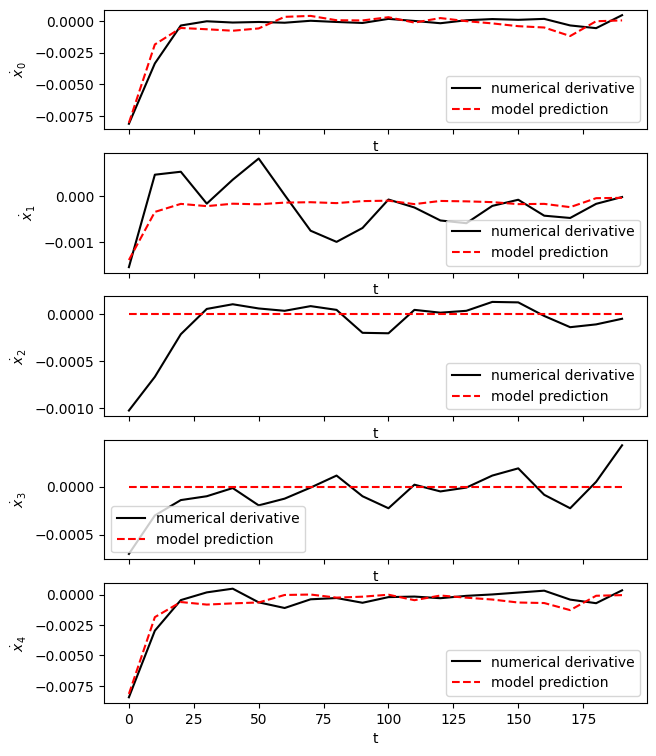

In [38]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold

KFold(n_splits=10)

model = SINDyCV()
x_dot = model.differentiate(x_true, t=t_data)

param_grid = {
    "optimizer__threshold": [0.0, 0.0001, 0.001, 0.01, 0.015, 0.02],
    "optimizer__alpha": [0.00001, 0.001, 0.005, 0.01, 0.05, 0.1, 0],
    "feature_library__degree": [1, 2 ],
}

search = GridSearchCV(
        model,
        param_grid,
        cv=ShuffleSplit(n_splits=5, test_size=0.7)
)
search.fit(x_true, y=x_dot)
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)
search.best_estimator_.print()

plot_model_prediction(search.best_estimator_, x_true, dt, max_time)